In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
# Kaggle Dataset Loading
import kagglehub

path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")
print("Path to dataset files:", path)

# Set dataset path
DATASET_PATH = os.path.join(path, "AugmentedAlzheimerDataset")

# Define categories
CATEGORIES = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

100%|██████████| 380M/380M [00:18<00:00, 21.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


In [ ]:
# Assuming dataset is downloaded and unzipped by KaggleHub
dataset_path = path  # Path returned by KaggleHub

# Check the dataset structure
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"Found {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

# Set up train and validation directories
data_dir = dataset_path

Found 2 directories and 0 files in /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1
Found 4 directories and 0 files in /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/OriginalDataset
Found 0 directories and 896 files in /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/OriginalDataset/MildDemented
Found 0 directories and 3200 files in /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/OriginalDataset/NonDemented
Found 0 directories and 2240 files in /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/OriginalDataset/VeryMildDemented
Found 0 directories and 64 files in /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/OriginalDataset/ModerateDemented
Found 4 directories and 0 files in /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/AugmentedAlzheimerD

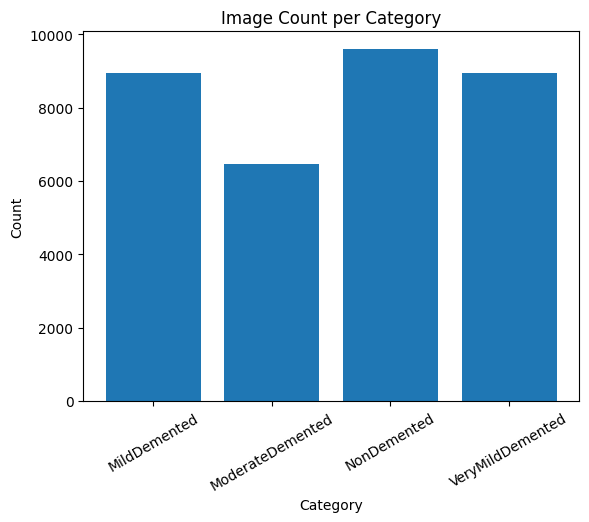

In [ ]:
# Check number of images per category
category_counts = {category: len(os.listdir(os.path.join(DATASET_PATH, category))) for category in CATEGORIES}
plt.bar(category_counts.keys(), category_counts.values())
plt.title("Image Count per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

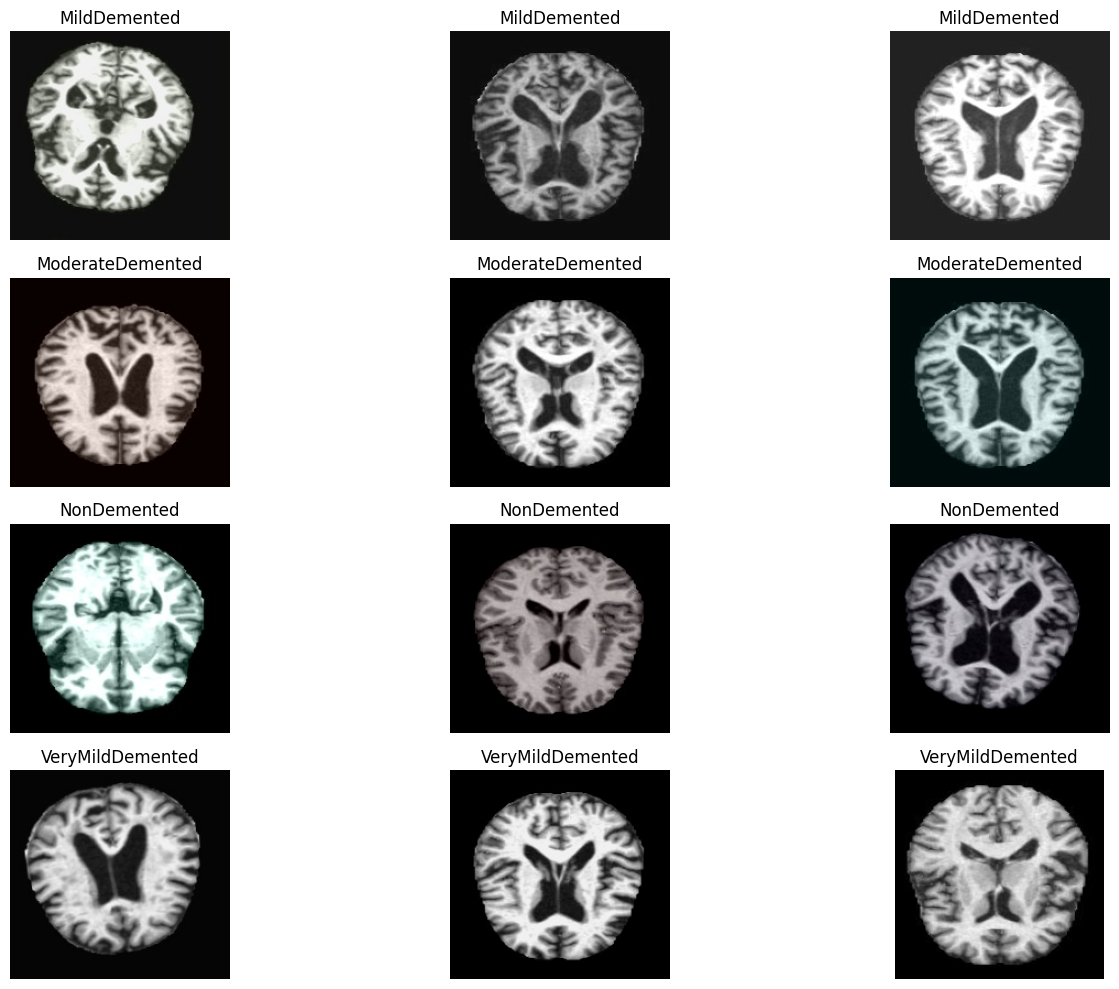

In [ ]:
# Display example images
def plot_example_images(dataset_path, categories, num_images=3):
    plt.figure(figsize=(15, 10))
    for idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)[:num_images]
        for i, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            img = plt.imread(img_path)
            plt.subplot(len(categories), num_images, idx * num_images + i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(category)
    plt.tight_layout()
    plt.show()

plot_example_images(DATASET_PATH, CATEGORIES)

In [ ]:
file_paths = []
labels = []
for label, category in enumerate(CATEGORIES):
    category_path = os.path.join(DATASET_PATH, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        file_paths.append(img_path)
        labels.append(category)

In [ ]:
data = {"file_path": file_paths, "label": labels}
df = pd.DataFrame(data)
img_df = df.sample(frac=1).reset_index(drop=True)
img_df.head()

,file_path,label
0,/root/.cache/kagglehub/datasets/uraninjo/augme...,ModerateDemented
1,/root/.cache/kagglehub/datasets/uraninjo/augme...,VeryMildDemented
2,/root/.cache/kagglehub/datasets/uraninjo/augme...,MildDemented
3,/root/.cache/kagglehub/datasets/uraninjo/augme...,VeryMildDemented
4,/root/.cache/kagglehub/datasets/uraninjo/augme...,NonDemented


In [ ]:
img_df['label'].value_counts()

,count
label,
NonDemented,9600
VeryMildDemented,8960
MildDemented,8960
ModerateDemented,6464


In [ ]:
label_mapping = {label: idx for idx, label in enumerate(img_df['label'].unique())}
img_df['label'] = img_df['label'].map(label_mapping)

In [ ]:
label_mapping

{'ModerateDemented': 0,
 'VeryMildDemented': 1,
 'MildDemented': 2,
 'NonDemented': 3}

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from collections import Counter

# Split the data
train_df, temp_df = train_test_split(img_df, test_size=0.2, stratify=img_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Extract filepaths and labels from train_df
filepaths_train = train_df['file_path']
labels_train = train_df['label']

# Reshape filepaths for oversampling
filepaths_train = filepaths_train.values.reshape(-1, 1)
labels_train = labels_train.values

# Apply oversampling to the training set
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
filepaths_resampled, labels_resampled = oversample.fit_resample(filepaths_train, labels_train)

# Create a new DataFrame for the oversampled training data
train_df_resampled = pd.DataFrame({
    'file_path': filepaths_resampled.flatten(),
    'label': labels_resampled
})

# Check the class distributions
print("Class distribution after oversampling (Training Set):", Counter(train_df_resampled['label']))
print("Class distribution in Validation Set:", Counter(val_df['label']))
print("Class distribution in Test Set:", Counter(test_df['label']))


Class distribution after oversampling (Training Set): Counter({1: 7680, 3: 7680, 0: 7680, 2: 7680})
Class distribution in Validation Set: Counter({3: 960, 1: 896, 2: 896, 0: 646})
Class distribution in Test Set: Counter({3: 960, 1: 896, 2: 896, 0: 647})


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [ ]:
print(f"Training samples: {len(train_df_resampled)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 30720
Validation samples: 3398
Test samples: 3399


In [ ]:
train_df_resampled.head()

,file_path,label
0,/root/.cache/kagglehub/datasets/uraninjo/augme...,1
1,/root/.cache/kagglehub/datasets/uraninjo/augme...,3
2,/root/.cache/kagglehub/datasets/uraninjo/augme...,1
3,/root/.cache/kagglehub/datasets/uraninjo/augme...,3
4,/root/.cache/kagglehub/datasets/uraninjo/augme...,3


In [ ]:
label_mapping = {idx: label for label, idx in label_mapping.items()}
label_mapping

{0: 'ModerateDemented',
 1: 'VeryMildDemented',
 2: 'MildDemented',
 3: 'NonDemented'}

In [ ]:
 # Reverse mapping
train_df_resampled['label'] = train_df_resampled['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

In [ ]:
train_df_resampled.head()

,file_path,label
0,/root/.cache/kagglehub/datasets/uraninjo/augme...,VeryMildDemented
1,/root/.cache/kagglehub/datasets/uraninjo/augme...,NonDemented
2,/root/.cache/kagglehub/datasets/uraninjo/augme...,VeryMildDemented
3,/root/.cache/kagglehub/datasets/uraninjo/augme...,NonDemented
4,/root/.cache/kagglehub/datasets/uraninjo/augme...,NonDemented


In [ ]:
# # Image Data Augmentation for training
# datagen = ImageDataGenerator(
#     rescale=1.0/255.0,         # Normalize pixel values to [0, 1]
#     rotation_range=20,         # Randomly rotate images by 20 degrees
#     width_shift_range=0.1,     # Randomly shift images horizontally by 10%
#     height_shift_range=0.1,    # Randomly shift images vertically by 10%
#     shear_range=0.2,           # Randomly shear images
#     zoom_range=0.2,            # Randomly zoom into images
#     horizontal_flip=True,      # Randomly flip images horizontally
#     fill_mode='nearest'        # Fill empty pixels after transformations
# )


In [ ]:
# Image dimensions
img_height, img_width = 176, 176
batch_size = 400

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

# No augmentation for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df_resampled,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 30720 validated image filenames belonging to 4 classes.
Found 3398 validated image filenames belonging to 4 classes.
Found 3399 validated image filenames belonging to 4 classes.


In [ ]:
# Dynamically determine the number of classes from the training generator
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

# Load the ResNet50 model with pretrained weights from ImageNet
# Include the top=False to exclude the top fully connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(176, 176, 3))

# Freeze the base_model layers to retain pretrained features
base_model.trainable = False

# Define the ResNet Model
model = Sequential([
    base_model,

    # Add custom layers on top
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='roc_auc', multi_label=True)
    ]
)

# Print the model summary
model.summary()

Number of classes: 4
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 6, 6, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,497,284 (162.11 MB)

 Trainable params: 18,908,804 (72.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks = [early_stopping]

# Measure training time
start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    steps_per_epoch=len(train_generator) // batch_size,
    validation_freq=1
)

end_time = time.time()

training_time = end_time - start_time
print(f"Training time for Resnet: {training_time:.2f} seconds")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4526 - loss: 1.4249 - precision: 0.5038 - recall: 0.3570 - roc_auc: 0.7065 - val_accuracy: 0.1922 - val_loss: 9.0517 - val_precision: 0.1920 - val_recall: 0.1919 - val_roc_auc: 0.5535
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 79s 846ms/step - accuracy: 0.6113 - loss: 0.8836 - precision: 0.6928 - recall: 0.5063 - roc_auc: 0.8379 - val_accuracy: 0.4005 - val_loss: 2.1121 - val_precision: 0.4174 - val_recall: 0.3567 - val_roc_auc: 0.7690
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 81s 829ms/step - accuracy: 0.6671 - loss: 0.7480 - precision: 0.7427 - recall: 0.5705 - roc_auc: 0.8735 - val_accuracy: 0.2454 - val_loss: 4.9754 - val_precision: 0.2428 - val_recall: 0.2366 - val_roc_auc: 0.6487
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 65s 799ms/step - accuracy: 0.6951 - loss: 0.6796 - precision: 0.7639 - recall: 0.6078 - roc_auc: 0.8932 - val_accuracy: 0.4447 - val_loss: 2.7372 - val_precision: 0.4447 - val_recall: 0.4447 - val_roc_auc: 0.7742
Epoch 5/2

In [ ]:
# Save the model
model.save('resnet_model.h5')
print("CNN model saved as 'resnet_model.h5'")

CNN model saved as 'resnet_model.h5'


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

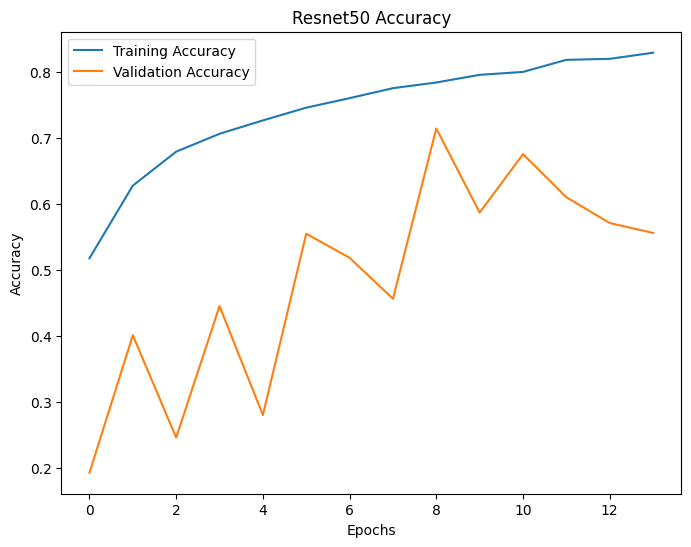

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Resnet50 Accuracy')
plt.legend()
plt.show()

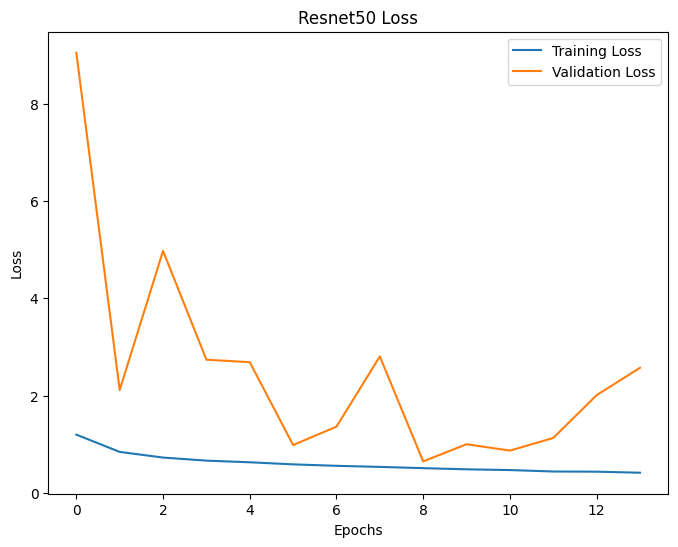

In [ ]:
# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Resnet50 Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
# Get the true and predicted labels
test_generator.reset()

# Measure testing time
start_time = time.time()
predictions = model.predict(test_generator)
end_time = time.time()

# Calculate testing time
testing_time = end_time - start_time

predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

print(f"Testing time for Resnet: {testing_time:.2f} seconds")

9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
Testing time for Resnet: 24.18 seconds


In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       896
           1       0.99      0.96      0.97       647
           2       0.57      0.87      0.69       960
           3       0.82      0.21      0.33       896

    accuracy                           0.71      3399
   macro avg       0.77      0.72      0.69      3399
weighted avg       0.75      0.71      0.67      3399



In [ ]:
label_mapping

{0: 'ModerateDemented',
 1: 'VeryMildDemented',
 2: 'MildDemented',
 3: 'NonDemented'}

In [ ]:
# Reverse the label mapping to get label names
label_names = [label_mapping[i] for i in range(len(label_mapping))]

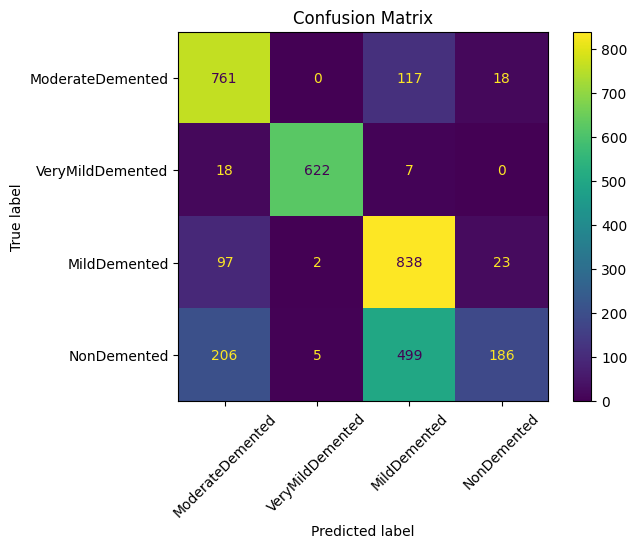

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

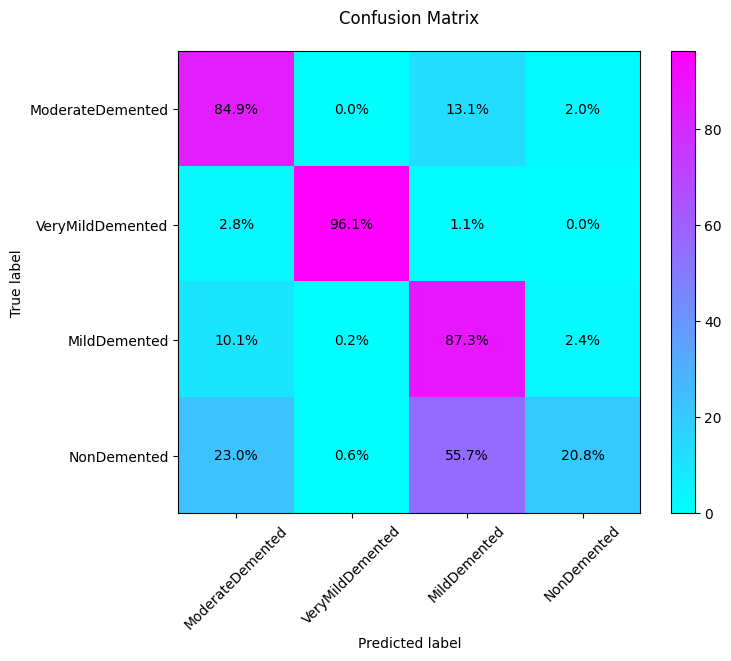

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentage symbol
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm_percentage, cmap='cool')

# Add colorbar
fig.colorbar(cax)

# Add labels and title
ax.set_title("Confusion Matrix", pad=20)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

ax.xaxis.set_ticks_position('bottom')

# Set axis ticks
# labels = list(label_mapping.keys())
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names)

# Annotate the matrix with percentage values and symbol
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        percentage = f"{cm_percentage[i, j]:.1f}%"
        ax.text(j, i, percentage, ha='center', va='center', color='black', fontsize=10)

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.7081
Precision: 0.7516
Recall: 0.7081
F1-Score: 0.6713


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class ROC-AUC
y_true_binarized = label_binarize(true_labels, classes=list(range(len(label_names))))

# Compute the multi-class ROC-AUC score
roc_auc = roc_auc_score(y_true_binarized, predictions, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.9228


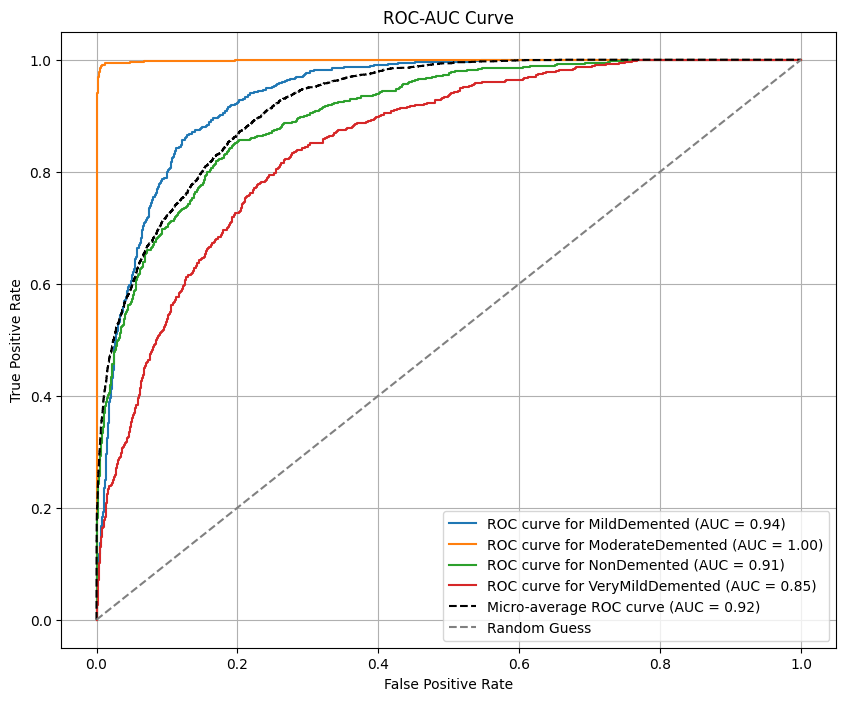

In [ ]:
# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10.colors  # Colors for each class curve
for i, class_name in enumerate(test_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"ROC curve for {class_name} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black', label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})")

# Plot the diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Labels and Legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()